In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import optuna

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, LogisticRegression

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost.callback import EarlyStopping
import lightgbm as lgbm

import os
import sys

from cycler import cycler
from colorama import Style, Fore

import warnings; warnings.filterwarnings('ignore')

sys.path.append('..')
from config import CFG
from src.visuals.fi import get_fi
CFG = CFG()
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', CFG.NCOLS)
pd.set_option('display.max_rows', CFG.NROWS)

In [11]:
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
grn = Style.BRIGHT + Fore.GREEN
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

palette = ['#3c3744', '#048BA8', '#EE6352', '#E1BB80', '#78BC61']
grey_palette = ['#8e8e93', '#636366', '#48484a', '#3a3a3c', '#2c2c2e', '#1c1c27']
bg_color = '#F6F5F5'
white_color = '#d1d1d6'

custom_params = {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.left': False,
    'grid.alpha':0.2,
    'figure.figsize': (16, 6),
    'axes.titlesize': 'large',
    'axes.labelsize': 'large',
    'ytick.labelsize': 'medium',
    'xtick.labelsize': 'medium',
    'legend.fontsize': 'large',
    'lines.linewidth': 1,
    'axes.prop_cycle': cycler('color',palette),
    'figure.facecolor': bg_color,
    'figure.edgecolor': bg_color,
    'axes.facecolor': bg_color,
    'text.color':grey_palette[1],
    'axes.labelcolor':grey_palette[1],
    'axes.edgecolor':grey_palette[1],
    'xtick.color':grey_palette[1],
    'ytick.color':grey_palette[1],
    'figure.dpi':150,
}
sns.set_theme(
    style='whitegrid',
    palette=sns.color_palette(palette),
    rc=custom_params)

In [41]:
train = pd.read_csv(os.path.join(CFG.RAW_DATA, 'train.csv')).drop(columns='id')
test = pd.read_csv(os.path.join(CFG.RAW_DATA, 'test.csv')).drop(columns='id')

In [42]:
def fe(df):
    df['Mean_DMSNR_Skewness_Ratio'] = df['Mean_DMSNR_Curve'] / df['Skewness_DMSNR_Curve']
    df['SD_Integrated_Skewness_Ratio'] = df['SD'] / df['Skewness']
    df['EK_Integrated_SD_Ratio'] = df['EK'] / df['SD']
    return df

train = fe(train)
test = fe(test)

In [43]:
scaler = RobustScaler()

y = train['Class']
X = train.drop(['Class'], axis=1)

XLR = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
testLR = pd.DataFrame(scaler.transform(test), columns=test.columns)

In [10]:
PATIENCE = 100

modelsCB = []
predsCB = []

k_fold = RepeatedStratifiedKFold(n_splits=CFG.NFOLDS, n_repeats=CFG.REPEATS, random_state=CFG.SEED) 

# gpu_params = {'task_type' : "GPU", 'devices' : '0:1'}
cbr_params = {
            'iterations':9999,
            'depth': 3,
            'learning_rate': 0.15687380686250746,
            'l2_leaf_reg': 4.0368544113430485,
            'random_strength': 0.1279482215776108,
            'max_bin': 238,
            'od_wait': 49,
            'one_hot_max_size': 39,
            'grow_policy': 'SymmetricTree',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            
            'random_state': 4228
        }

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = catboost.CatBoostRegressor(**cbr_params)
    
    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          early_stopping_rounds = PATIENCE,
          verbose=150,
         )
    modelsCB.append(model)
    predsCB.append(model.predict(test))

0:	learn: 0.2506373	test: 0.2505454	best: 0.2505454 (0)	total: 29.6ms	remaining: 4m 56s
150:	learn: 0.0864254	test: 0.0858570	best: 0.0858570 (150)	total: 2.44s	remaining: 2m 39s
300:	learn: 0.0846253	test: 0.0852429	best: 0.0852333 (289)	total: 4.33s	remaining: 2m 19s
450:	learn: 0.0833767	test: 0.0850156	best: 0.0850156 (450)	total: 6.21s	remaining: 2m 11s
600:	learn: 0.0822802	test: 0.0849809	best: 0.0849448 (552)	total: 8.12s	remaining: 2m 7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.08494482033
bestIteration = 552

Shrink model to first 553 iterations.
0:	learn: 0.2505041	test: 0.2507059	best: 0.2507059 (0)	total: 21.8ms	remaining: 3m 37s
150:	learn: 0.0852180	test: 0.0874576	best: 0.0874576 (150)	total: 1.88s	remaining: 2m 2s
300:	learn: 0.0834048	test: 0.0871334	best: 0.0871156 (288)	total: 3.82s	remaining: 2m 3s
450:	learn: 0.0822601	test: 0.0869792	best: 0.0869551 (409)	total: 5.68s	remaining: 2m
600:	learn: 0.0810454	test: 0.0869078	best: 0.0868542 

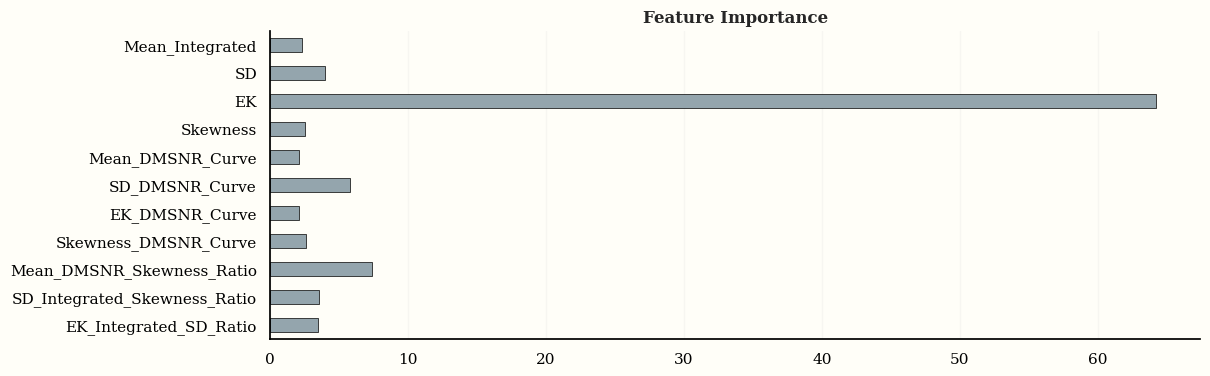

In [24]:
get_fi(modelsCB, X, CFG, "CatBoost Regressor")

In [35]:
modelsXB = []
predsXB = []

PATIENCE = 50

xgbr_params = {
            'n_estimators':9999,
            'max_depth': 4,
            'learning_rate': 0.06333221939055333,
            'min_child_weight': 4,
            'gamma': 5.301218558776368e-08,
            'subsample': 0.41010429946197946,
            'colsample_bytree': 0.8298539920447499,
            'reg_alpha': 0.000517878113716743,
            'reg_lambda': 0.00030121415155097723,
            'n_jobs': -1,
            'objective': 'binary:logistic',
            'verbosity': 0,
            'eval_metric': 'logloss',
            'random_state': 4228}

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = XGBRegressor(**xgbr_params)
    
    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          early_stopping_rounds = PATIENCE,
          verbose = 100
         )
    modelsXB.append(model)
    predsXB.append(model.predict(test))

[01:50:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	fit-logloss:0.63385	val-logloss:0.63380
[150]	fit-logloss:0.02819	val-logloss:0.02933
[243]	fit-logloss:0.02609	val-logloss:0.02911
[01:50:50] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	fit-logloss:0.63378	val-logloss:0.63384
[150]	fit-logloss:0.02710	val-logloss:0.03179
[300]	fit-logloss:0.02400	val-logloss:0.03170
[309]	fit-logloss:0.02384	val-logloss:0.03170
[01:51:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	fit-logloss:0.63373	val-logloss:0.63383
[150]	fit-logloss:0.02629	val-lo

In [36]:
modelsLB = []
predsLB = []

PATIENCE = 50

# gpu_params = {'device' : "gpu"}
lgbr_params = {
    'n_estimators': 9999,
    'max_depth': 5,
    'learning_rate': 0.05293702575527996,
    'subsample': 0.20851841295589477,
    'colsample_bytree': 0.5784778854092203,
    'reg_alpha': 0.2622912287429849,
    'reg_lambda': 2.8702494234117617e-08,
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    
    'random_state': CFG.SEED
}

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = lgbm.LGBMRegressor(**lgbr_params)
    
    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          early_stopping_rounds = PATIENCE,
          verbose = 100
         )
    modelsLB.append(model)
    predsLB.append(model.predict(test))

[100]	valid_0's rmse: 0.0848124
[200]	valid_0's rmse: 0.0842693
[100]	valid_0's rmse: 0.0872226
[200]	valid_0's rmse: 0.0869251
[100]	valid_0's rmse: 0.0900459
[200]	valid_0's rmse: 0.0897858
[100]	valid_0's rmse: 0.0856939
[200]	valid_0's rmse: 0.0852411
[100]	valid_0's rmse: 0.0883816
[100]	valid_0's rmse: 0.0885554
[200]	valid_0's rmse: 0.0880178
[300]	valid_0's rmse: 0.0878983
[100]	valid_0's rmse: 0.0862299
[200]	valid_0's rmse: 0.0859385
[300]	valid_0's rmse: 0.085836
[100]	valid_0's rmse: 0.0887659
[200]	valid_0's rmse: 0.0886085
[100]	valid_0's rmse: 0.0861506
[200]	valid_0's rmse: 0.0854567


In [38]:
modelsLR = []
predsLR = []

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
test = pd.DataFrame(scaler.transform(test), columns=test.columns)

lasso_par = {
    'alpha': 0.06448185915751528,
    'max_iter': 10000,
    'tol': 0.007029268232213037    
}

MODEL_PARAMS = {
    'precompute': "auto",
    'fit_intercept': True,
    'normalize': False,
    'max_iter': 10000,
    'verbose': False,
    'eps': 0.013,
    'cv': 3,
    'n_alphas': 1000,
    'n_jobs': 8,
    'tol': 0.0001
}


for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = Lasso(**lasso_par)
    
    model.fit(X=X_train, y=y_train,
         )
    
    modelsLR.append(model)
    predsLR.append(model.predict(test))

In [75]:
def coef_objective(trial):
    a = trial.suggest_float('a', 0, 1)
    b = trial.suggest_float('b', 0.5, 1)
    c = trial.suggest_float('c', 0.5, 1)
    e = trial.suggest_float('e', 0, 0.01)

    preds_eval = []
    for model in modelsCB:
        preds_eval.append(model.predict(X))
    
    resCB = np.average(np.array(preds_eval),axis=0)
    
    preds_eval = []
    for model in modelsXB:
        preds_eval.append(model.predict(xgb.DMatrix(X)))
    
    resXB = np.average(np.array(preds_eval),axis=0)
    
    preds_eval = []
    for model in modelsLB:
        preds_eval.append(model.predict(X))
    
    resLB = np.average(np.array(preds_eval),axis=0)
    
    preds_eval = []
    for model in modelsLR:
        preds_eval.append(model.predict(XLR))
    
    resLR = np.average(np.array(preds_eval),axis=0)
    
    
    res1 =  (resCB * a + resXB * b + resLB * c + resLR * e)/(a + b + c + e)
    
    res = mean_squared_error(y, res1, squared=False)

    return res

study = optuna.create_study(direction= 'minimize')

[I 2023-03-13 03:00:35,594] A new study created in memory with name: no-name-84ba4602-f13c-4033-885f-a6de656685dd


In [76]:
study.optimize(coef_objective, n_trials=50)
coef_dict = study.best_params
coef_dict

[I 2023-03-13 03:01:04,249] Trial 0 finished with value: 0.08003163247462207 and parameters: {'a': 0.16851633109073927, 'b': 0.6865808449811319, 'c': 0.7333619259545843, 'e': 0.002531054741477019}. Best is trial 0 with value: 0.08003163247462207.
[I 2023-03-13 03:01:30,038] Trial 1 finished with value: 0.0800316506916319 and parameters: {'a': 0.17150189478068645, 'b': 0.9216355399802652, 'c': 0.6281365459071047, 'e': 0.009825720303447512}. Best is trial 0 with value: 0.08003163247462207.
[I 2023-03-13 03:01:54,440] Trial 2 finished with value: 0.08006532704223727 and parameters: {'a': 0.20087089569805727, 'b': 0.6941015622466558, 'c': 0.8279219347697916, 'e': 0.0063946526711473745}. Best is trial 0 with value: 0.08003163247462207.
[I 2023-03-13 03:02:22,016] Trial 3 finished with value: 0.08021165699243608 and parameters: {'a': 0.40149735924707897, 'b': 0.6591764008698964, 'c': 0.8162073707652356, 'e': 0.007034141117414299}. Best is trial 0 with value: 0.08003163247462207.
[I 2023-03-1

{'a': 0.001116156911952916,
 'b': 0.593021413208358,
 'c': 0.5225395657176285,
 'e': 0.0012648566554668578}

In [81]:
predCB = np.average(np.array(predsCB),axis=0)
predXB = np.average(np.array(predsXB),axis=0)
predLB = np.average(np.array(predsLB),axis=0)
predLR = np.average(np.array(predsLR),axis=0)

pred = predCB * coef_dict['a'] + predXB * coef_dict['b'] + predLB * coef_dict['c'] + predLR * coef_dict['e']

In [82]:
submission = pd.read_csv(os.path.join(CFG.DATA_PATH, 'sample_submission.csv'))
submission['Class'] = pred
submission.to_csv(os.path.join(CFG.BASE_PATH, 'submissions', 'CT-XG-LGB-LR_noclippedv2.csv'), index=False)